# Following Roy's Previous work with Pytorch version but with BEiT

In [1]:
%pip install --upgrade pip
%pip install -r requirements.txt

/bin/bash: /home/bestlab/anaconda3/envs/jeff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/bestlab/anaconda3/envs/jeff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python==4.7.0.72

/bin/bash: /home/bestlab/anaconda3/envs/jeff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import BeitImageProcessor, BeitForImageClassification, BeitConfig
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.notebook import tqdm

from sklearn.metrics import RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, confusion_matrix

from sklearn.mixture import GaussianMixture

In [4]:
# get generic path to directory
dir_path = "/home/bestlab/Desktop/Squishy-Methane-Analysis/0 - GasNet/" 

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

In [5]:
print(data_dir)

/home/bestlab/Desktop/Squishy-Methane-Analysis/0 - GasNet/data


In [6]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges_Seconds.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [7]:
'''
Tailored Dataset Object from PyTorch

Info on Dataset Object:
- An abstract class representing a Dataset
- All datasets that represent a map from keys to data samples should subclass it
- All subclasses should overwrite __getitem__, supporting fetching a data sample for a given key
- Subclasses could also optionally overwrite __len__, which is expected to return the size of the dataset by many ~torch.utils.data
- Sampler implementations and the default options of ~torch.utils.data.DataLoader
- Subclasses could also optionally implement __getitems__, for speedup batched samples loading
- This method accepts list of indices of samples of batch and returns list of samples

'''


class MultiClassVideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, processor=None):
        self.root_dir = root_dir
        self.transform = transform
        self.processor = processor
        self.classes = os.listdir(root_dir)  # Get class names from subdirectories

        self.frames = []
        self.labels = []

        #populates frames and labels with frames and labels from the subdirectories leak and nonleak
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            frame_list = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
            self.frames.extend(frame_list)
            self.labels.extend([class_idx] * len(frame_list))
    #returns the length of frames (total frames => both leak and nonleak)
    def __len__(self):
        return len(self.frames)
    
    #returns the (image, label) at a given index
    #if a self.transform is set applies transform
    #if a self.processor is set applies processor more info at https://huggingface.co/docs/transformers/v4.34.1/en/main_classes/image_processor
    def __getitem__(self, idx):
        frame_path = self.frames[idx]
        image = cv2.imread(frame_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        if self.transform:
            image = self.transform(image)
        
        if self.processor:
            image = self.processor.preprocess(image, return_tensors="pt")

        label = self.labels[idx]

        return image, label

In [8]:
image_processor = BeitImageProcessor(
    "microsoft/beit-base-patch16-224-pt22k-ft22k",
    do_normalize=True,
    max_size=384,
    pad_to_max_size=True
)

transform = None

In [9]:
full_train_dataset = MultiClassVideoFrameDataset(root_dir=frame_train_data_dir, transform=transform, processor=image_processor)
test_dataset = MultiClassVideoFrameDataset(root_dir=frame_test_data_dir, transform=transform, processor=image_processor)

# Define the percentage of data to use for validation
validation_split = 0.2  # Adjust this as needed

# Calculate the number of samples for the validation set
num_samples = len(full_train_dataset)
num_val_samples = int(validation_split * num_samples)
num_train_samples = num_samples - num_val_samples

# Create a list of indices for the full dataset
indices = list(range(num_samples))

# Use random sampling to split the indices into train and validation indices
val_indices = torch.randperm(num_samples)[:num_val_samples]
train_indices = list(set(indices) - set(val_indices))

# Create Subset objects for train and validation
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
len(full_train_dataset) + len(test_dataset)

584636

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
configs = BeitConfig(
    hidden_dropout_prob=0.5,
    attention_probs_dropout_prob=0.2
)

In [13]:
# Initialize the ViT feature extractor and model
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k', config=configs, ignore_mismatched_sizes=True)
model.to(device)


Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k were not used when initializing BeitForImageClassification: ['beit.encoder.layer.10.attention.attention.relative_position_bias.relative_position_bias_table', 'beit.encoder.layer.6.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.1.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.4.attention.attention.relative_position_bias.relative_position_bias_table', 'beit.encoder.layer.11.attention.attention.relative_position_bias.relative_position_bias_table', 'beit.encoder.layer.4.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.10.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.5.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.7.attention.attention.relative_position_bias.relative_position_bias_table', 'beit.encoder

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
          )
          (intermediate): BeitIntermediate(
            (dense): Linear(in_featur

In [14]:
# Change classifier layer to have num classes consistent with dataset
model.classifier.out_features = len(full_train_dataset.classes)
model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [15]:
train_dataloader.dataset.dataset.classes

['Leak', 'Nonleaks']

In [16]:
def train(model, weight=None, num_epochs=10):
    criterion = nn.CrossEntropyLoss(weight=weight) # extendable for multiclass classification as well
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # can try out lr scheduler later if needed
    # can also try out warmup ratio

    for epoch in range(num_epochs):
        model.train()
        for batch_images, batch_labels in tqdm(train_dataloader):
            batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_image_pixels).logits
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        model.eval()
        accuracy = 0
        total_samples = 0

        with torch.no_grad():
            for batch_images, batch_labels in tqdm(val_dataloader, leave=False):
                batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
                outputs = model(batch_image_pixels).logits
                _, predicted = torch.max(outputs, 1)
                accuracy += (predicted == batch_labels).sum().item()
                total_samples += batch_labels.size(0)

        validation_accuracy = accuracy / total_samples
        print(f"Validation Accuracy: {validation_accuracy:.4f}")

In [17]:
# Adjust Class weights here
class_weight = torch.tensor([1, 8]).float().to(device)

In [18]:
train(model, class_weight, 5)

  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.4206


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.4321


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.6141


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.4338


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.4750


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.4355


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.4477


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.3836


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.3657


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.3036


In [19]:
def predict(model):
    model.eval()
    accuracy = 0
    total_samples = 0
    predictions = []  # List to store the predictions
    truth_labels = []  # List to store the truth labels

    with torch.no_grad():
        for batch_images, batch_labels in tqdm(test_dataloader, leave=False):
            batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
            outputs = model(batch_image_pixels).logits
            _, predicted = torch.max(outputs, 1)
            accuracy += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

            predictions.extend(predicted.cpu().numpy())
            truth_labels.extend(batch_labels.cpu().numpy())

    validation_accuracy = accuracy / total_samples
    print(f"Test Accuracy: {validation_accuracy:.4f}")
    return predictions, truth_labels

In [20]:
predictions, truth_labels = predict(model)
predictions, truth_labels = np.array(predictions), np.array(truth_labels)

  0%|          | 0/7402 [00:00<?, ?it/s]

Test Accuracy: 0.3126


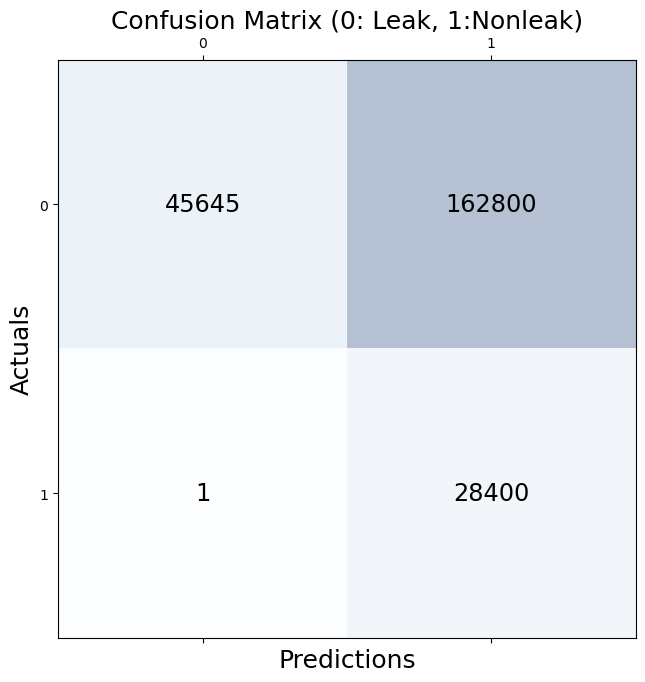

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=truth_labels.astype(int), y_pred=predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix (0: Leak, 1:Nonleak)', fontsize=18)
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(truth_labels, predictions)
accuracy

0.3126293034292325

In [23]:
f1 = f1_score(truth_labels, predictions)
f1

0.2586509168901781

In [24]:
conf_matrix = confusion_matrix(truth_labels, predictions)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for label, acc in zip(['Leak', 'Nonleak'], per_class_accuracy):
    print(f"Class '{label}' Accuracy: {acc:.4f}")

Class 'Leak' Accuracy: 0.2190
Class 'Nonleak' Accuracy: 1.0000
